# 01 - Data Analysis and Preparation

This notebook covers the following tasks:

1. Perform exploratory data analysis and visualization.
2. Prepare the data for the ML task in BigQuery.
3. Generate and fix a ` TFDV schema` for the source data.
4. Create a `Vertex Dataset resource` dataset.


## Dataset

Credit Card Fraud https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Load the data:

```
$ bq load --skip_leading_rows=1 vertex_eu.creditcards creditcard.csv Time:STRING,V1:FLOAT,V2:FLOAT,V3:FLOAT,V4:FLOAT,V5:FLOAT,V6:FLOAT,V7:FLOAT,V8:FLOAT,V9:FLOAT,V10:FLOAT,V11:FLOAT,V12:FLOAT,V13:FLOAT,V14:FLOAT,V15:FLOAT,V16:FLOAT,V17:FLOAT,V18:FLOAT,V19:FLOAT,V20:FLOAT,V21:FLOAT,V22:FLOAT,V23:FLOAT,V24:FLOAT,V25:FLOAT,V26:FLOAT,V27:FLOAT,V28:FLOAT,Amount:FLOAT,Class:STRING
```

The ML task is to predict whether a given operation is fraudulent.

## Setup

### Import libraries

In [1]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow_data_validation as tfdv
from google.cloud import bigquery
import matplotlib.pyplot as plt

from google.cloud import aiplatform as vertex_ai

### Setup Google Cloud project

In [17]:
#PROJECT = 'cxb1-prj-test-no-vpcsc'
PROJECT = 'pbalm-cxb-aa'
REGION = 'us-central1'

if PROJECT == "" or PROJECT is None or PROJECT == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT = shell_output[0]
    
print("Project ID:", PROJECT)
print("Region:", REGION)

Project ID: pbalm-cxb-aa
Region: us-central1


### Set configurations

In [18]:
!bq --location=$BQ_LOCATION mk -d \
$PROJECT:$BQ_DATASET_NAME

BigQuery error in mk operation: Dataset 'pbalm-cxb-aa:vertex_us' already exists.


Upload the data!


In [19]:
BQ_DATASET_NAME = 'vertex_us' # Change to your BQ dataset name.
BQ_TABLE_NAME = 'chicago_taxitrips_prep'
BQ_LOCATION = 'US'

DATASET_DISPLAY_NAME = 'chicago-taxi-tips'

RAW_SCHEMA_DIR = 'src/raw_schema'

In [20]:
!yes | gcloud config set project {PROJECT}

Updated property [core/project].
yes: standard output: Broken pipe


## 1. Explore the data in BigQuery

In [21]:
from google.cloud import bigquery

client = bigquery.Client()  

sql = f"SELECT * FROM `{PROJECT}.{BQ_SOURCE_TABLE}` LIMIT 10"
print(sql)

query_job = client.query(sql, location=BQ_LOCATION)
df = query_job.result().to_dataframe()

SELECT * FROM `pbalm-cxb-aa.vertex_eu.creditcards` LIMIT 10


NotFound: 404 Not found: Dataset pbalm-cxb-aa:vertex_eu was not found in location US

Location: US
Job ID: c6e0885a-3fc5-4fc9-9170-3dcf0dfbc031


In [ ]:
df.head()

In [8]:
%%bigquery data --project {PROJECT} --verbose

SELECT 
  Class, count(*) as n
FROM `vertex_eu.creditcards`
GROUP BY Class


Executing query with job ID: 8ced9e25-4ebc-46ca-9612-51d137360905
Query executing: 0.24s
Query complete after 0.41s


Downloading: 100%|██████████| 2/2 [00:00<00:00,  2.00rows/s]


In [9]:
data

,Class,n
0,0,284315
1,1,492


<AxesSubplot:xlabel='Class'>

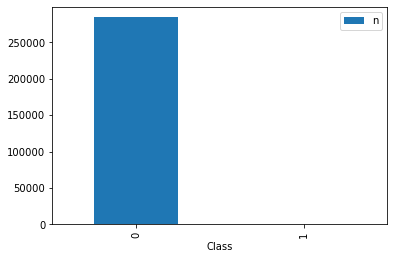

In [10]:
data.plot(kind='bar', x='Class', y='n')

## 2. Create data for the ML task

We add a `ML_use` column for pre-splitting the data, where 80% of the datsa items are set to `UNASSIGNED` while the other 20% is set to `TEST`.

This column is used during training to split the dataset for training and test.

In the training phase, the `UNASSIGNED` are split into `train` and `eval`. The `TEST` split is will be used for the final model validation.

### Create destination BigQuery dataset

In [11]:
sample_size = 1000000
year = 2020
#SOURCE_TABLE='`bigquery-public-data.chicago_taxi_trips.taxi_trips`'
#SOURCE_TABLE='`mlops1-notebooks.vertex_eu.taxi_trips`'

In [12]:
sql_script = '''
CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TABLE` 
AS (
    WITH
      taxitrips AS (
      SELECT
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        @SOURCE_TABLE
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      CONCAT(
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickup_longitude,
              pickup_latitude), 0.1)), 
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropoff_longitude,
              dropoff_latitude), 0.1))
      ) AS loc_cross,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      IF(RAND() <= 0.8, 'UNASSIGNED', 'TEST') AS ML_use
    FROM
      `@SOURCE_TABLE`
    LIMIT @LIMIT
)
'''

In [13]:
sql_script = sql_script.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(year)).replace(
    '@LIMIT', str(sample_size)).replace(
    '@SOURCE_TABLE', BQ_SOURCE_TABLE)
    

NameError: name 'BQ_TABLE_NAME' is not defined

In [ ]:
print(sql_script)

In [ ]:
bq_client = bigquery.Client(project=PROJECT, location=BQ_LOCATION)
job = bq_client.query(sql_script)
_ = job.result()

In [ ]:
%%bigquery --project {PROJECT}

SELECT ML_use, COUNT(*)
FROM vertex_eu.chicago_taxitrips_prep # Change to your BQ dataset and table names.
GROUP BY ML_use

### Load a sample data to a Pandas DataFrame

In [ ]:
%%bigquery sample_data --project {PROJECT}

SELECT * EXCEPT (trip_start_timestamp, ML_use)
FROM  vertex_eu.chicago_taxitrips_prep # Change to your BQ dataset and table names.

In [ ]:
sample_data.head().T

In [ ]:
sample_data.tip_bin.value_counts()

In [ ]:
sample_data.euclidean.hist()

## 3. Generate raw data schema

The [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) data schema will be used in:
1. Identify the raw data types and shapes in the data transformation.
2. Create the serving input signature for the custom model.
3. Validate the new raw training data in the TFX pipeline.

In [ ]:
stats = tfdv.generate_statistics_from_dataframe(
    dataframe=sample_data,
    stats_options=tfdv.StatsOptions(
        label_feature='tip_bin',
        weight_feature=None,
        sample_rate=1,
        num_top_values=50
    )
)

In [ ]:
tfdv.visualize_statistics(stats)

In [ ]:
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_schema(schema=schema)

In [ ]:
raw_schema_location = os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt')
tfdv.write_schema_text(schema, raw_schema_location)

## 4. Create Vertex Dataset resource

In [ ]:
print("Project ID:", PROJECT)
print("Region:", REGION)

vertex_ai.init(
    project=PROJECT,
    location=REGION
)

### Create the dataset resource

In [ ]:
bq_uri = f"bq://{PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}"

dataset = vertex_ai.TabularDataset.create(
    display_name=DATASET_DISPLAY_NAME, bq_source=bq_uri)

dataset.gca_resource

### Get the dataset resource

The dataset resource is retrieved by display name. Because multiple datasets can have the same display name, we retrieve the most recent updated one.

In [ ]:
dataset = vertex_ai.TabularDataset.list(
    filter=f"display_name={DATASET_DISPLAY_NAME}", 
    order_by="update_time")[-1]

print("Dataset resource name:", dataset.resource_name)
print("Dataset BigQuery source:", dataset.gca_resource.metadata['inputConfig']['bigquerySource']['uri'])